# IQS Data Explorer Example

This notebook demonstrates how to use the unified configuration system with the Text2Cypher workflow to analyze Honda vehicle customer feedback data.

In [1]:
import sys

# Add the project root to Python path
sys.path.append("../..")

In [2]:
from dotenv import load_dotenv
from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from neo4j_text2cypher.retrievers import ConfigCypherExampleRetriever
from neo4j_text2cypher.utils.config import ConfigLoader
from neo4j_text2cypher.workflows.neo4j_text2cypher_workflow import create_neo4j_text2cypher_workflow
from neo4j_text2cypher.utils.debug import setup_debug_logging

In [3]:
# Load environment variables
load_dotenv()

True

## Initialize Components

Load configuration and set up the Neo4j graph connection, LLM, and unified Cypher example retriever.

In [4]:
# Load unified configuration
config_path = "app-config.yml"
config_loader = ConfigLoader(config_path)

# debug logging based on config
debug_config = config_loader.get_debug_config()
setup_debug_logging(debug_config)

# Initialize Neo4j graph connection (uses environment variables)
graph = Neo4jGraph(enhanced_schema=True)
print("Connected to Neo4j")
print(f"Schema: {graph.schema[:500]}...")  # Print first 500 chars of schema

Connected to Neo4j
Schema: Node properties:
- **Customer**
  - `id`: STRING Example: "9A79438B"
  - `ageBucket`: STRING Example: ">=70"
  - `gender`: STRING Available options: ['Male', 'Female', '']
- **Category**
  - `id`: STRING Available options: ['Exterior', 'Driving Experience', 'Features/Controls/Displays (FCD)', 'Driving Assistance', 'Infotainment', 'Seats', 'Climate', 'Interior', 'Powertrain']
- **Problem**
  - `id`: STRING Example: "EXT01"
  - `problem`: STRING Example: "EXT01: Doors - Hard to open/close"
- **Que...


In [5]:
# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)
print("LLM initialized")

LLM initialized


In [6]:
# Initialize unified Cypher example retriever
cypher_example_retriever = ConfigCypherExampleRetriever(config_path=config_path)

# Get Streamlit configuration for scope description
streamlit_config = config_loader.get_streamlit_config()
print(f"Loaded {len(config_loader.get_example_queries())} example queries from: {config_path}")
print(f"App: {streamlit_config.title}")
print(f"Scope: {streamlit_config.scope_description[:100]}...")

Loaded 16 example queries from: app-config.yml
App: IQS Data Explorer
Scope: This application may answer questions related to customer feedback on Honda vehicles....


## Create the Workflow

Set up the text2cypher workflow using the unified configuration system.

In [7]:
# Create the workflow using unified configuration
agent = create_neo4j_text2cypher_workflow(
    llm=llm,
    graph=graph,
    scope_description=streamlit_config.scope_description,
    cypher_example_retriever=cypher_example_retriever,
    max_attempts=3,
    attempt_cypher_execution_on_final_attempt=False
)

print("Text2Cypher workflow created successfully!")
print(f"Configuration loaded from: {config_path}")

Text2Cypher workflow created successfully!
Configuration loaded from: app-config.yml


## Visualize the Workflow

Display the workflow graph to understand the execution flow.

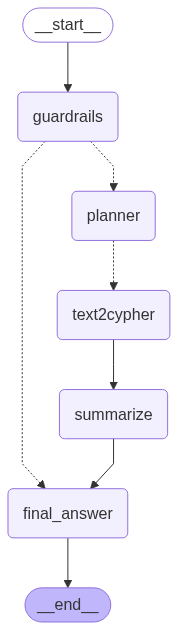

In [8]:
from IPython.display import Image, display

try:
    # Display the workflow graph
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Workflow structure:")
    print("Input → Guardrails → Planner → Text2Cypher → Summarize → Validate → Final Answer")

Visualization below with more detail on the Text2Cypher component

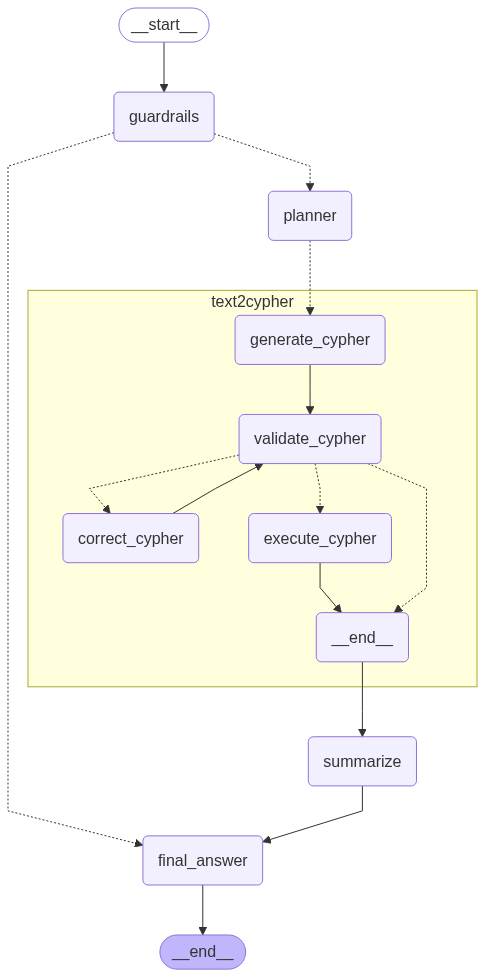

In [9]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Example Usage

Run some example questions from the configuration through the workflow.

In [10]:
# Use the first example question from configuration
question = streamlit_config.example_questions[0]
print(f"Testing with example question: {question}")

response = await agent.ainvoke({
    "question": question,
    "data": [],
    "history": []
})

print(f"Question: {response.get('question')}")
print(f"\nAnswer: {response.get('answer')}")

Testing with example question: How many vehicles are there?
Question: How many vehicles are there?

Answer: 12


## Examine the Results

Look at the generated Cypher queries and execution steps.

In [11]:
# Display the execution steps
print("Execution Steps:")
for step in response.get("steps", []):
    print(f"  - {step}")

Execution Steps:
  - guardrails
  - planner
  - ['generate_cypher', 'validate_cypher', 'execute_cypher']
  - summarize
  - final_answer


In [12]:
# Display generated Cypher queries and results
cyphers = response.get("cyphers", [])
print(f"\nGenerated {len(cyphers)} Cypher queries:")

for i, cypher_result in enumerate(cyphers):
    print(f"\n--- Query {i+1} ---")
    print(f"Task: {cypher_result.get('task')}")
    print(f"Cypher: {cypher_result.get('statement')}")
    
    records = cypher_result.get('records', [])
    print(f"Results: {len(records)} records")
    
    # Show first few records
    for j, record in enumerate(records[:3]):
        print(f"  Record {j+1}: {record}")
    
    if len(records) > 3:
        print(f"  ... and {len(records) - 3} more records")


Generated 1 Cypher queries:

--- Query 1 ---
Task: How many vehicles are there?
Cypher: MATCH (v:Vehicle)
RETURN COUNT(v) AS totalVehicles
LIMIT 100
Results: 1 records
  Record 1: {'totalVehicles': 12}


## Test an array of questions with memory management

In [14]:
# Define your conversation as an array of questions
questions = [
    "How many responses are under Honda Civic?",
    "Can you summarize responses related to doors for that same vehicle?"
]

async def run_conversation(questions_list, agent):
    """Run a conversation with automatic history management."""

    # Start with empty history - LangGraph will manage it
    current_state = {
        "question": "",
        "data": [],
        "history": []
    }

    print("🚀 Starting Conversation...\n")

    for i, question in enumerate(questions_list, 1):
        print(f"{'='*60}")
        print(f"QUESTION {i}: {question}")
        print(f"{'='*60}")

        # Update the question in state
        current_state["question"] = question

        # Get response from agent
        response = await agent.ainvoke(current_state)

        # Extract and display results
        answer = response.get('answer', 'No answer provided')
        cyphers = response.get('cyphers', [])
        history = response.get('history', [])

        print(f"📝 Answer:\n{answer}")
        print(f"🔍 Cyphers executed: {len(cyphers)}")
        print(f"💭 History entries: {len(history)}")

        # Show cypher details
        for j, cypher in enumerate(cyphers):
            print(f"\n  Cypher {j+1}:")
            print(f"    Task: {cypher.get('task', 'No task')}")
            print(f"    Statement: {cypher.get('statement', 'No statement')[:100]}...")
            print(f"    Records: {len(cypher.get('records', []))} records")
            if cypher.get('errors'):
                print(f"    ❌ Errors: {cypher.get('errors')}")

        # ✨ Key: Use the returned history for the next question
        # LangGraph automatically updates the history in the response
        current_state["history"] = history

        print(f"\n✅ Question {i} completed. History updated.\n")

    print("🎉 Conversation completed!")
    return current_state["history"]

# Run the conversation
final_history = await run_conversation(questions, agent)

# Optional: Inspect the final conversation history
print(f"\n📚 Final conversation history ({len(final_history)} entries):")
for i, record in enumerate(final_history):
    print(f"{i+1}. Q: {record['question'][:50]}...")
    print(f"   A: {record['answer'][:50]}...")

🚀 Starting Conversation...

QUESTION 1: How many responses are under Honda Civic?
📝 Answer:
965 responses
🔍 Cyphers executed: 1
💭 History entries: 1

  Cypher 1:
    Task: How many responses are under Honda Civic?
    Statement: MATCH (v:Verbatim {make: "Honda", model: "Civic"})
RETURN COUNT(v) AS totalResponses
LIMIT 100...
    Records: 1 records

✅ Question 1 completed. History updated.

QUESTION 2: Can you summarize responses related to doors for that same vehicle?
📝 Answer:
- Black cloth seats and door panels show dirt, lint, and scuffs easily.
- Driver's seat belt adjustment mechanism and door panels can rattle or squeak.
- Door trim and seals may have installation issues, leading to rattles and water leaks.
- Cupholders are insufficient and do not fit certain brands of insulated bottles.
- Interior materials, including door panels, are prone to scratches and scuffs.
- Doors may require more force to close properly, and there are issues with door locks and unlocking behavior.
- So